In [1]:
"""Module implements an agent that uses OpenAI's APIs function enabled API."""
from typing import Any, List, Optional, Sequence, Tuple, Type, Union

from langchain_core._api import deprecated
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.callbacks import BaseCallbackManager, Callbacks
from langchain_core.language_models import BaseLanguageModel
from langchain_core.messages import (
    BaseMessage,
    SystemMessage,
)
from langchain_core.prompts import BasePromptTemplate
from langchain_core.prompts.chat import (
    BaseMessagePromptTemplate,
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    MessagesPlaceholder,
)
from langchain_core.pydantic_v1 import root_validator
from langchain_core.runnables import Runnable, RunnablePassthrough
from langchain_core.tools import BaseTool
from langchain_core.utils.function_calling import convert_to_openai_function

from langchain.agents import BaseSingleActionAgent
from langchain.agents.format_scratchpad.openai_functions import (
    format_to_openai_function_messages,
)
from langchain.agents.output_parsers.openai_functions import (
    OpenAIFunctionsAgentOutputParser,
)


@deprecated("0.1.0", alternative="create_openai_functions_agent", removal="0.2.0")
class OpenAIFunctionsAgent(BaseSingleActionAgent):
    """An Agent driven by OpenAIs function powered API.

    Args:
        llm: This should be an instance of ChatOpenAI, specifically a model
            that supports using `functions`.
        tools: The tools this agent has access to.
        prompt: The prompt for this agent, should support agent_scratchpad as one
            of the variables. For an easy way to construct this prompt, use
            `OpenAIFunctionsAgent.create_prompt(...)`
    """

    llm: BaseLanguageModel
    tools: Sequence[BaseTool]
    prompt: BasePromptTemplate
    output_parser: Type[
        OpenAIFunctionsAgentOutputParser
    ] = OpenAIFunctionsAgentOutputParser

    def get_allowed_tools(self) -> List[str]:
        """Get allowed tools."""
        return [t.name for t in self.tools]

    @root_validator
    def validate_prompt(cls, values: dict) -> dict:
        prompt: BasePromptTemplate = values["prompt"]
        if "agent_scratchpad" not in prompt.input_variables:
            raise ValueError(
                "`agent_scratchpad` should be one of the variables in the prompt, "
                f"got {prompt.input_variables}"
            )
        return values

    @property
    def input_keys(self) -> List[str]:
        """Get input keys. Input refers to user input here."""
        return ["input"]

    @property
    def functions(self) -> List[dict]:
        return [dict(convert_to_openai_function(t)) for t in self.tools]

    def plan(
        self,
        intermediate_steps: List[Tuple[AgentAction, str]],
        callbacks: Callbacks = None,
        with_functions: bool = True,
        **kwargs: Any,
    ) -> Union[AgentAction, AgentFinish]:
        """Given input, decided what to do.

        Args:
            intermediate_steps: Steps the LLM has taken to date, along with observations
            **kwargs: User inputs.

        Returns:
            Action specifying what tool to use.
        """
        agent_scratchpad = format_to_openai_function_messages(intermediate_steps)
        selected_inputs = {
            k: kwargs[k] for k in self.prompt.input_variables if k != "agent_scratchpad"
        }
        full_inputs = dict(**selected_inputs, agent_scratchpad=agent_scratchpad)
        prompt = self.prompt.format_prompt(**full_inputs)
        messages = prompt.to_messages()
        if with_functions:
            predicted_message = self.llm.predict_messages(
                messages,
                functions=self.functions,
                callbacks=callbacks,
            )
        else:
            predicted_message = self.llm.predict_messages(
                messages,
                callbacks=callbacks,
            )
        agent_decision = self.output_parser._parse_ai_message(predicted_message)
        return agent_decision

    async def aplan(
        self,
        intermediate_steps: List[Tuple[AgentAction, str]],
        callbacks: Callbacks = None,
        **kwargs: Any,
    ) -> Union[AgentAction, AgentFinish]:
        """Given input, decided what to do.

        Args:
            intermediate_steps: Steps the LLM has taken to date,
                along with observations
            **kwargs: User inputs.

        Returns:
            Action specifying what tool to use.
        """
        agent_scratchpad = format_to_openai_function_messages(intermediate_steps)
        selected_inputs = {
            k: kwargs[k] for k in self.prompt.input_variables if k != "agent_scratchpad"
        }
        full_inputs = dict(**selected_inputs, agent_scratchpad=agent_scratchpad)
        prompt = self.prompt.format_prompt(**full_inputs)
        messages = prompt.to_messages()
        predicted_message = await self.llm.apredict_messages(
            messages, functions=self.functions, callbacks=callbacks
        )
        agent_decision = self.output_parser._parse_ai_message(predicted_message)
        return agent_decision

    def return_stopped_response(
        self,
        early_stopping_method: str,
        intermediate_steps: List[Tuple[AgentAction, str]],
        **kwargs: Any,
    ) -> AgentFinish:
        """Return response when agent has been stopped due to max iterations."""
        if early_stopping_method == "force":
            # `force` just returns a constant string
            return AgentFinish(
                {"output": "Agent stopped due to iteration limit or time limit."}, ""
            )
        elif early_stopping_method == "generate":
            # Generate does one final forward pass
            agent_decision = self.plan(
                intermediate_steps, with_functions=False, **kwargs
            )
            if isinstance(agent_decision, AgentFinish):
                return agent_decision
            else:
                raise ValueError(
                    f"got AgentAction with no functions provided: {agent_decision}"
                )
        else:
            raise ValueError(
                "early_stopping_method should be one of `force` or `generate`, "
                f"got {early_stopping_method}"
            )

    @classmethod
    def create_prompt(
        cls,
        system_message: Optional[SystemMessage] = SystemMessage(
            content="You are a helpful AI assistant."
        ),
        extra_prompt_messages: Optional[List[BaseMessagePromptTemplate]] = None,
    ) -> ChatPromptTemplate:
        """Create prompt for this agent.

        Args:
            system_message: Message to use as the system message that will be the
                first in the prompt.
            extra_prompt_messages: Prompt messages that will be placed between the
                system message and the new human input.

        Returns:
            A prompt template to pass into this agent.
        """
        _prompts = extra_prompt_messages or []
        messages: List[Union[BaseMessagePromptTemplate, BaseMessage]]
        if system_message:
            messages = [system_message]
        else:
            messages = []

        messages.extend(
            [
                *_prompts,
                HumanMessagePromptTemplate.from_template("{input}"),
                MessagesPlaceholder(variable_name="agent_scratchpad"),
            ]
        )
        return ChatPromptTemplate(messages=messages)

    @classmethod
    def from_llm_and_tools(
        cls,
        llm: BaseLanguageModel,
        tools: Sequence[BaseTool],
        callback_manager: Optional[BaseCallbackManager] = None,
        extra_prompt_messages: Optional[List[BaseMessagePromptTemplate]] = None,
        system_message: Optional[SystemMessage] = SystemMessage(
            content="You are a helpful AI assistant."
        ),
        **kwargs: Any,
    ) -> BaseSingleActionAgent:
        """Construct an agent from an LLM and tools."""
        prompt = cls.create_prompt(
            extra_prompt_messages=extra_prompt_messages,
            system_message=system_message,
        )
        return cls(
            llm=llm,
            prompt=prompt,
            tools=tools,
            callback_manager=callback_manager,
            **kwargs,
        )


def create_openai_functions_agent(
    llm: BaseLanguageModel, tools: Sequence[BaseTool], prompt: ChatPromptTemplate
) -> Runnable:
    """Create an agent that uses OpenAI function calling.

    Args:
        llm: LLM to use as the agent. Should work with OpenAI function calling,
            so either be an OpenAI model that supports that or a wrapper of
            a different model that adds in equivalent support.
        tools: Tools this agent has access to.
        prompt: The prompt to use. See Prompt section below for more.

    Returns:
        A Runnable sequence representing an agent. It takes as input all the same input
        variables as the prompt passed in does. It returns as output either an
        AgentAction or AgentFinish.

    Example:

        Creating an agent with no memory

        .. code-block:: python

            from langchain_community.chat_models import ChatOpenAI
            from langchain.agents import AgentExecutor, create_openai_functions_agent
            from langchain import hub

            prompt = hub.pull("hwchase17/openai-functions-agent")
            model = ChatOpenAI()
            tools = ...

            agent = create_openai_functions_agent(model, tools, prompt)
            agent_executor = AgentExecutor(agent=agent, tools=tools)

            agent_executor.invoke({"input": "hi"})

            # Using with chat history
            from langchain_core.messages import AIMessage, HumanMessage
            agent_executor.invoke(
                {
                    "input": "what's my name?",
                    "chat_history": [
                        HumanMessage(content="hi! my name is bob"),
                        AIMessage(content="Hello Bob! How can I assist you today?"),
                    ],
                }
            )

    Prompt:

        The agent prompt must have an `agent_scratchpad` key that is a
            ``MessagesPlaceholder``. Intermediate agent actions and tool output
            messages will be passed in here.

        Here's an example:

        .. code-block:: python

            from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

            prompt = ChatPromptTemplate.from_messages(
                [
                    ("system", "You are a helpful assistant"),
                    MessagesPlaceholder("chat_history", optional=True),
                    ("human", "{input}"),
                    MessagesPlaceholder("agent_scratchpad"),
                ]
            )
    """
   
   
    if "agent_scratchpad" not in prompt.input_variables:
        raise ValueError(
            "Prompt must have input variable `agent_scratchpad`, but wasn't found. "
            f"Found {prompt.input_variables} instead."
        )
    llm_with_tools = llm.bind(functions=[convert_to_openai_function(t) for t in tools])
    agent = (
        RunnablePassthrough.assign(
            agent_scratchpad=lambda x: format_to_openai_function_messages(
                x["intermediate_steps"]
            )
        )
        | prompt
        | llm_with_tools
        | OpenAIFunctionsAgentOutputParser()
    )
    return agent


In [26]:
# Ollama functions


import json
from typing import Any, Dict, List, Optional

from langchain_community.chat_models.ollama import ChatOllama
from langchain_core.callbacks import CallbackManagerForLLMRun
from langchain_core.language_models import BaseChatModel
from langchain_core.messages import AIMessage, BaseMessage
from langchain_core.outputs import ChatGeneration, ChatResult
from langchain_core.prompts import SystemMessagePromptTemplate

from langchain_experimental.pydantic_v1 import root_validator

DEFAULT_SYSTEM_TEMPLATE = """You have access to the following tools:

{tools}

You must always select one of the above tools and respond with only a JSON object matching the following schema:

{{
  "tool": <name of the selected tool>,
  "tool_input": <parameters for the selected tool, matching the tool's JSON schema>
}}
"""  # noqa: E501


DEFAULT_RESPONSE_FUNCTION = {
    "name": "__conversational_response",
    "description": (
        "Respond conversationally if no other tools should be called for a given query."
    ),
    "parameters": {
        "type": "object",
        "properties": {
            "response": {
                "type": "string",
                "description": "Conversational response to the user.",
            },
        },
        "required": ["response"],
    },
}


class OllamaFunctions(BaseChatModel):
    """Function chat model that uses Ollama API."""

    llm: ChatOllama

    tool_system_prompt_template: str

    @root_validator(pre=True)
    def validate_environment(cls, values: Dict) -> Dict:
        values["llm"] = values.get("llm") or ChatOllama(**values, format="json")
        values["tool_system_prompt_template"] = (
            values.get("tool_system_prompt_template") or DEFAULT_SYSTEM_TEMPLATE
        )
        return values

    @property
    def model(self) -> BaseChatModel:
        """For backwards compatibility."""
        return self.llm

    def _generate(
        self,
        messages: List[BaseMessage],
        stop: Optional[List[str]] = None,
        run_manager: Optional[CallbackManagerForLLMRun] = None,
        **kwargs: Any,
    ) -> ChatResult:
        functions = kwargs.get("functions", [])
        if "function_call" in kwargs:
            functions = [
                fn for fn in functions if fn["name"] == kwargs["function_call"]["name"]
            ]
            if not functions:
                raise ValueError(
                    'If "function_call" is specified, you must also pass a matching \
function in "functions".'
                )
            del kwargs["function_call"]
        elif not functions:
            functions.append(DEFAULT_RESPONSE_FUNCTION)
        system_message_prompt_template = SystemMessagePromptTemplate.from_template(
            self.tool_system_prompt_template
        )
        system_message = system_message_prompt_template.format(
            tools=json.dumps(functions, indent=2)
        )
        if "functions" in kwargs:
            del kwargs["functions"]
        response_message = self.llm.predict_messages(
            [system_message] + messages, stop=stop, callbacks=run_manager, **kwargs
        )
        chat_generation_content = response_message.content
        if not isinstance(chat_generation_content, str):
            raise ValueError("OllamaFunctions does not support non-string output.")
        try:
            parsed_chat_result = json.loads(chat_generation_content)
        except json.JSONDecodeError:

# Custom code : ------

            return ChatResult(
                generations=[
                    ChatGeneration(
                        message=AIMessage(
                            content=chat_generation_content,
                        )
                    )
                ]
            )
            
            
# Custom code : -------
            # raise ValueError(
            #     f'"{self.llm.model}" did not respond with valid JSON. Please try again.'
            # )
        called_tool_name = parsed_chat_result["tool"]
        called_tool_arguments = parsed_chat_result["tool_input"]
        called_tool = next(
            (fn for fn in functions if fn["name"] == called_tool_name), None
        )
        if called_tool is None:
            raise ValueError(
                f"Failed to parse a function call from {self.llm.model} \
output: {chat_generation_content}"
            )
        if called_tool["name"] == DEFAULT_RESPONSE_FUNCTION["name"]:
            return ChatResult(
                generations=[
                    ChatGeneration(
                        message=AIMessage(
                            content=called_tool_arguments["response"],
                        )
                    )
                ]
            )

        response_message_with_functions = AIMessage(
            content="",
            additional_kwargs={
                "function_call": {
                    "name": called_tool_name,
                    "arguments": json.dumps(called_tool_arguments)
                    if called_tool_arguments
                    else "",
                },
            },
        )

        return ChatResult(
            generations=[ChatGeneration(message=response_message_with_functions)]
        )

    @property
    def _llm_type(self) -> str:
        return "ollama_functions"


In [13]:
# Create agent executor 


import operator
from typing import Annotated, Sequence, TypedDict, Union

from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
from langchain_core.runnables import RunnableLambda

from langgraph.graph import END, StateGraph
from langgraph.prebuilt.tool_executor import ToolExecutor


def _get_agent_state(input_schema=None):
    if input_schema is None:

        class AgentState(TypedDict):
            # The input string
            input: str
            # The list of previous messages in the conversation
            chat_history: Sequence[BaseMessage]
            # The outcome of a given call to the agent
            # Needs `None` as a valid type, since this is what this will start as
            agent_outcome: Union[AgentAction, AgentFinish, None]
            # List of actions and corresponding observations
            # Here we annotate this with `operator.add` to indicate that operations to
            # this state should be ADDED to the existing values (not overwrite it)
            intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

    else:

        class AgentState(input_schema):
            # The outcome of a given call to the agent
            # Needs `None` as a valid type, since this is what this will start as
            agent_outcome: Union[AgentAction, AgentFinish, None]
            # List of actions and corresponding observations
            # Here we annotate this with `operator.add` to indicate that operations to
            # this state should be ADDED to the existing values (not overwrite it)
            intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

    return AgentState


def create_agent_executor(agent_runnable, tools, input_schema=None):
    if isinstance(tools, ToolExecutor):
        tool_executor = tools
    else:
        tool_executor = ToolExecutor(tools)

    state = _get_agent_state(input_schema)

    # Define logic that will be used to determine which conditional edge to go down

    def should_continue(data):
        # If the agent outcome is an AgentFinish, then we return `exit` string
        # This will be used when setting up the graph to define the flow
        if isinstance(data["agent_outcome"], AgentFinish):
            return "end"
        # Otherwise, an AgentAction is returned
        # Here we return `continue` string
        # This will be used when setting up the graph to define the flow
        else:
            return "continue"

    def run_agent(data):
        agent_outcome = agent_runnable.invoke(data)
        return {"agent_outcome": agent_outcome}

    async def arun_agent(data):
        agent_outcome = await agent_runnable.ainvoke(data)
        return {"agent_outcome": agent_outcome}

    # Define the function to execute tools
    def execute_tools(data):
        # Get the most recent agent_outcome - this is the key added in the `agent` above
        agent_action = data["agent_outcome"]
        output = tool_executor.invoke(agent_action)
        return {"intermediate_steps": [(agent_action, str(output))]}

    async def aexecute_tools(data):
        # Get the most recent agent_outcome - this is the key added in the `agent` above
        agent_action = data["agent_outcome"]
        output = await tool_executor.ainvoke(agent_action)
        return {"intermediate_steps": [(agent_action, str(output))]}

    # Define a new graph
    workflow = StateGraph(state)

    # Define the two nodes we will cycle between
    workflow.add_node("agent", RunnableLambda(run_agent, arun_agent))
    workflow.add_node("action", RunnableLambda(execute_tools, aexecute_tools))

    # Set the entrypoint as `agent`
    # This means that this node is the first one called
    workflow.set_entry_point("agent")

    # We now add a conditional edge
    workflow.add_conditional_edges(
        # First, we define the start node. We use `agent`.
        # This means these are the edges taken after the `agent` node is called.
        "agent",
        # Next, we pass in the function that will determine which node is called next.
        should_continue,
        # Finally we pass in a mapping.
        # The keys are strings, and the values are other nodes.
        # END is a special node marking that the graph should finish.
        # What will happen is we will call `should_continue`, and then the output of that
        # will be matched against the keys in this mapping.
        # Based on which one it matches, that node will then be called.
        {
            # If `tools`, then we call the tool node.
            "continue": "action",
            # Otherwise we finish.
            "end": END,
        },
    )

    # We now add a normal edge from `tools` to `agent`.
    # This means that after `tools` is called, `agent` node is called next.
    workflow.add_edge("action", "agent")

    # Finally, we compile it!
    # This compiles it into a LangChain Runnable,
    # meaning you can use it as you would any other runnable
    return workflow.compile()


Tools

Execution agent

In [7]:
from langchain_community.tools.tavily_search import TavilySearchResults
from dotenv import load_dotenv
load_dotenv()

tools = [TavilySearchResults(max_results=3)]

In [8]:
from langchain import hub
import os
# from langchain.agents import create_openai_functions_agent
from langchain_openai import ChatOpenAI
from langchain_community.chat_models import ChatOllama 
# from langchain_experimental.llms.ollama_functions import OllamaFunctions

# Get the prompt to use - you can modify this!
prompt = hub.pull("hwchase17/openai-functions-agent")
# Choose the LLM that will drive the agent
# llm = ChatOpenAI(model="gpt-4-turbo-preview")
llm = OllamaFunctions(model=os.environ['LLM'])
# Construct the OpenAI Functions agent
agent_runnable = create_openai_functions_agent(llm, tools, prompt)

# agent_runnable = OpenAIFunctionsAgent.from_llm_and_tools(llm=llm, tools=tools)


In [9]:
prompt.pretty_print()

================================ System Message ================================

You are a helpful assistant

============================= Messages Placeholder =============================

{chat_history}

================================ Human Message =================================

{input}

============================= Messages Placeholder =============================

{agent_scratchpad}


In [10]:
agent_runnable.plan

AttributeError: 'RunnableSequence' object has no attribute 'plan'

In [12]:
# from langgraph.prebuilt import create_agent_executor

agent_executor = create_agent_executor(agent_runnable, tools)

agent_executor.invoke({'input': 'who is the ceo of zoho', 'chat_history': []})

{'input': 'who is the ceo of zoho',
 'chat_history': [],
 'agent_outcome': AgentFinish(return_values={'output': '{\n\n"I see that you\'re interested in Sridhar Vembu, the CEO of Zoho. He recently revealed his eco-friendly office space on a farm which was built with a simple rule of thumb - to create less waste and consume fewer resources. He is also known for taking software development functions from urban centers into rural villages in India, and has been a strong advocate for India as a tech investment destination. If you\'d like to read more about him, I can share some articles I found."\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n'}, log='{\n\n"I see that you\'re interested in Sridhar Vembu, the CEO of Zoho. He recently revealed his eco-friendly office space on a farm which was built with a simple rule of thumb - to create less waste and consume fewer resources. He is also known for taking software development functions from urban centers into rural villages in In

In [5]:
{'input': 'who is the ceo of zoho',
 'chat_history': [],
 'agent_outcome': AgentFinish(return_values={'output': '{\n\n"I see that you\'re interested in Sridhar Vembu, the CEO of Zoho. He recently revealed his eco-friendly office space on a farm which was built with a simple rule of thumb - to create less waste and consume fewer resources. He is also known for taking software development functions from urban centers into rural villages in India, and has been a strong advocate for India as a tech investment destination. If you\'d like to read more about him, I can share some articles I found."\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n'}, log='{\n\n"I see that you\'re interested in Sridhar Vembu, the CEO of Zoho. He recently revealed his eco-friendly office space on a farm which was built with a simple rule of thumb - to create less waste and consume fewer resources. He is also known for taking software development functions from urban centers into rural villages in India, and has been a strong advocate for India as a tech investment destination. If you\'d like to read more about him, I can share some articles I found."\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n'),
 'intermediate_steps': [(AgentActionMessageLog(tool='tavily_search_results_json', tool_input={'query': 'Who is the CEO of Zoho?'}, log="\nInvoking: `tavily_search_results_json` with `{'query': 'Who is the CEO of Zoho?'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "Who is the CEO of Zoho?"}'}})]),
   '[{\'url\': \'https://en.wikipedia.org/wiki/Zoho_Corporation\', \'content\': "In July 2022, the company announced it had more than 80 million users.[17][18]\\nZoholics India is the name of the company\'s annual user conference.[14]\\nOther products include Zoho Books, an accounting software, Zoho Workplace, an enterprise collaboration platform, Zoho Survey, a customer experience management tool, and Zoho People, an HR management platform.[14]\\nIn March of 2023, Zoho collaborated with Payoneer, a financial technology company that assists with businesses to make transactions easier.[19] Radha Vembu, Sridhar Vembu\'s sister, owns a majority stake in the company.[6]\\nHistory[edit]\\nFrom 1996 to 2009, the company was known as AdventNet, Inc. and initially provided network management software.[7][8]\\nAdventNet expanded operations into Japan in 2001 and shifted focus to small and medium businesses (SMBs).[8]\\nZoho CRM was released in 2005, along with Zoho Writer, the company\'s first Office suite product.[8] In 2008, the company added invoicing and mail applications, reaching one million users by August of that year.[9]\\nIn 2009, the company was renamed Zoho Corporation after its online office suite.[10] The company remains privately owned.[11]\\nIn 2017, Zoho launched Zoho One, a comprehensive suite of over forty applications.[12] Zoho opened an office in Tenkasi in 2011, where their product Zoho Desk was built and launched.[28][29]\\nAfter the outbreak of COVID-19 Zoho[30] planned to open branches in rural areas in southern Tamil Nadu including Madurai and Theni. The company was founded in 1996[3] by Sridhar Vembu and Tony Thomas and has a presence in seven locations with global headquarters in Chennai, Tamil Nadu, India, and corporate headquarters outside of Austin in Del Valle, Texas.[4][5]"}, {\'url\': \'https://en.wikipedia.org/wiki/Sridhar_Vembu\', \'content\': \'The employee stated that Vembu was hostile to him for criticising the Rashtriya Swayamsevak Sangh (RSS), a Hindu nationalist paramilitary organisation.[17][18]\\nIn January 2020, Vembu met with criticism after he attended, as the guest of honour, a high-profile event organised by the RSS.[19][20][21] Vembu defended his participation as a matter of his personal choice.[22][23][24]\\nHonours\\nVembu was awarded the 2019 Ernst & Young "Entrepreneur of the Year Award" in India.[25] Specifically, his company, Zoho, established its offices in rural Mathalamparai, Tenkasi district, Tamil Nadu and in suburban Renigunta, Andhra Pradesh.[6][13] He moved from the Bay Area to Mathalamparai at this time.[14]\\nIn 2004, he set up Zoho Schools[clarification needed] to provide vocational software development education to rural students as an alternative to formal university education.[15] A statement from the company states that 15 to 20 percent of its engineers have no college degree, but have received vocational education from Zoho Schools.[6] He graduated with a bachelor\\\'s degree in Electrical Engineering from the Indian Institute of Technology, Madras in 1989, and earned his MS and PhD degrees from Princeton University in New Jersey.[6]\\nCareer\\nVembu launched his professional career working for Qualcomm as a wireless engineer in San Diego, California, before moving to the San Francisco Bay Area. He was awarded India\\\'s fourth highest civilian award, the Padma Shri, in 2021.[4][5]\\nEarly life\\nVembu was born in 1968 in a middle class Tamil Brahmin family, in a village in Thanjavur district, Tamil Nadu.[6][7][citation needed] In 2021, Sridhar Vembu was appointed to National Security Advisory Board.[11] Despite being a unicorn, Zoho has been completely bootstrapped by Vembu and his co-founder Tony Thomas to avoid external influence.[12]\\nSocial entrepreneurship\\nSridhar Vembu is noted[further explanation needed] for taking software and product development functions from urban centers into rural villages in India.\'}, {\'url\': \'https://www.forbes.com/profile/sridhar-vembu-siblings/\', \'content\': \'Sridhar Vembu is the founder and CEO of privately held Zoho, a maker of cloud-based business software. Vembu, who owns a majority stake in Zoho with his siblings, started the business as AdventNet ...\'}]'),
  (AgentActionMessageLog(tool='tavily_search_results_json', tool_input={'query': 'ceo of zoho sridhar vembu'}, log="\nInvoking: `tavily_search_results_json` with `{'query': 'ceo of zoho sridhar vembu'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "ceo of zoho sridhar vembu"}'}})]),
   '[{\'url\': \'https://m.economictimes.com/magazines/panache/this-idyllic-thatched-hut-is-actually-an-office-welcome-to-zoho-ceo-sridhar-vembus-eco-friendly-workplace/articleshow/91129859.cms\', \'content\': \'Recently, the CEO of Zoho Sridhar Vembu took to Twitter to share with his followers a glimpse of his office space. The Padma Shri awardee shared pictures of his new office that is built on a farm. The Padma Shri awardee shared pictures of his new office that is built on a farm.\'}, {\'url\': \'https://timesofindia.indiatimes.com/technology/tech-news/zoho-founder-and-ceo-sridhar-vembu-our-rule-of-thumb-is-simple-/articleshow/108961982.cms\', \'content\': "Zoho\'s CEO, Sridhar Vembu, champions India as a tech investment destination, stressing talent development and long-term commitment. He envisions India\'s impact on global industries through ..."}, {\'url\': \'https://en.wikipedia.org/wiki/Sridhar_Vembu\', \'content\': \'The employee stated that Vembu was hostile to him for criticising the Rashtriya Swayamsevak Sangh (RSS), a Hindu nationalist paramilitary organisation.[17][18]\\nIn January 2020, Vembu met with criticism after he attended, as the guest of honour, a high-profile event organised by the RSS.[19][20][21] Vembu defended his participation as a matter of his personal choice.[22][23][24]\\nHonours\\nVembu was awarded the 2019 Ernst & Young "Entrepreneur of the Year Award" in India.[25] Specifically, his company, Zoho, established its offices in rural Mathalamparai, Tenkasi district, Tamil Nadu and in suburban Renigunta, Andhra Pradesh.[6][13] He moved from the Bay Area to Mathalamparai at this time.[14]\\nIn 2004, he set up Zoho Schools[clarification needed] to provide vocational software development education to rural students as an alternative to formal university education.[15] A statement from the company states that 15 to 20 percent of its engineers have no college degree, but have received vocational education from Zoho Schools.[6] He graduated with a bachelor\\\'s degree in Electrical Engineering from the Indian Institute of Technology, Madras in 1989, and earned his MS and PhD degrees from Princeton University in New Jersey.[6]\\nCareer\\nVembu launched his professional career working for Qualcomm as a wireless engineer in San Diego, California, before moving to the San Francisco Bay Area. He was awarded India\\\'s fourth highest civilian award, the Padma Shri, in 2021.[4][5]\\nEarly life\\nVembu was born in 1968 in a middle class Tamil Brahmin family, in a village in Thanjavur district, Tamil Nadu.[6][7][citation needed] In 2021, Sridhar Vembu was appointed to National Security Advisory Board.[11] Despite being a unicorn, Zoho has been completely bootstrapped by Vembu and his co-founder Tony Thomas to avoid external influence.[12]\\nSocial entrepreneurship\\nSridhar Vembu is noted[further explanation needed] for taking software and product development functions from urban centers into rural villages in India.\'}]')]}

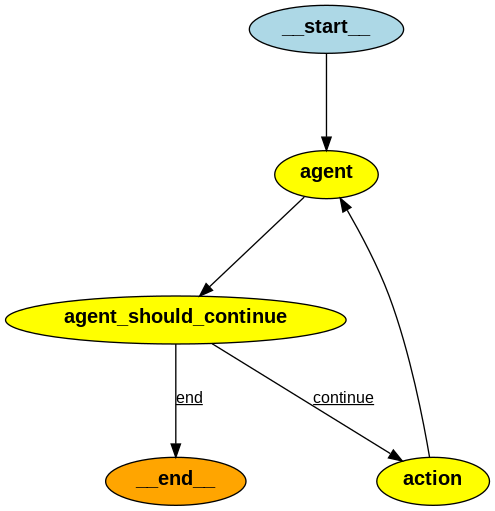

In [6]:

from IPython.display import Image

Image(gg.get_graph().draw_png())


State

In [14]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List, Tuple, Annotated, TypedDict
import operator


class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str


Planning

In [18]:
from langchain_core.pydantic_v1 import BaseModel
from langchain_community.chat_models import ChatOllama
import os
from dotenv import load_dotenv 
load_dotenv()

class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )
    
    
from langchain.chains.openai_functions import create_structured_output_runnable
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

{objective}"""
)
planner = create_structured_output_runnable(
    Plan, llm, planner_prompt
)



In [19]:
planner.invoke(
    {"objective": "what is the hometown of the current Australia open winner?"}
)


Plan(steps=['Visit a reliable source for obtaining information about the current Australia Open winner, such as the official Australia Open website or a reputable sports news outlet.', 'Locate and access the section of the website or news outlet that provides information on past winners and their respective hometowns.', "Search for the most recent Australia Open winner's name and verify the accuracy of the information.", "Record the winner's hometown from the reliable source.", "Format the output as required: {hometown: <winner's hometown>}"])

Re-plan

In [20]:
import json
from typing import Any, Callable, Dict, Literal, Optional, Sequence, Type, Union

from langchain_core.output_parsers import (BaseGenerationOutputParser, BaseOutputParser,)
from langchain_core.output_parsers.openai_functions import (JsonOutputFunctionsParser, PydanticOutputFunctionsParser,)
from langchain_core.prompts import BasePromptTemplate
from langchain_core.pydantic_v1 import BaseModel
from langchain_core.runnables import Runnable
from langchain_core.utils.function_calling import (convert_to_openai_function)

from langchain.output_parsers import (JsonOutputKeyToolsParser, PydanticOutputParser, PydanticToolsParser)


def create_openai_fn_runnable(
    functions: Sequence[Union[Dict[str, Any], Type[BaseModel], Callable]],
    llm: Runnable,
    prompt: Optional[BasePromptTemplate] = None,
    *,
    enforce_single_function_usage: bool = True,
    output_parser: Optional[Union[BaseOutputParser, BaseGenerationOutputParser]] = None,
    **llm_kwargs: Any,
) -> Runnable:
   
    openai_functions = [convert_to_openai_function(f) for f in functions]
    llm_kwargs_: Dict[str, Any] = {"functions": openai_functions, **llm_kwargs}
    
    if len(openai_functions) == 1 and enforce_single_function_usage:
        llm_kwargs_["function_call"] = {"name": openai_functions[0]["name"]}
    output_parser = output_parser or get_openai_output_parser(functions)
    if prompt:
        return prompt | llm.bind(**llm_kwargs_) | output_parser
    else:
        return llm.bind(**llm_kwargs_) | output_parser


def get_openai_output_parser(
    functions: Sequence[Union[Dict[str, Any], Type[BaseModel], Callable]],
) -> Union[BaseOutputParser, BaseGenerationOutputParser]:
    """Get the appropriate function output parser given the user functions.

    Args:
        functions: Sequence where element is a dictionary, a pydantic.BaseModel class,
            or a Python function. If a dictionary is passed in, it is assumed to
            already be a valid OpenAI function.

    Returns:
        A PydanticOutputFunctionsParser if functions are Pydantic classes, otherwise
            a JsonOutputFunctionsParser. If there's only one function and it is
            not a Pydantic class, then the output parser will automatically extract
            only the function arguments and not the function name.
    """
    if isinstance(functions[0], type) and issubclass(functions[0], BaseModel):
        if len(functions) > 1:
            pydantic_schema: Union[Dict, Type[BaseModel]] = {
                convert_to_openai_function(fn)["name"]: fn for fn in functions
            }
        else:
            pydantic_schema = functions[0]
        output_parser: Union[
            BaseOutputParser, BaseGenerationOutputParser
        ] = PydanticOutputFunctionsParser(pydantic_schema=pydantic_schema)
    else:
        output_parser = JsonOutputFunctionsParser(args_only=len(functions) <= 1)
    return output_parser



In [22]:
# from langchain.chains.openai_functions import create_openai_fn_runnable


class Response(BaseModel):
    """Response to user."""

    response: str


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = create_openai_fn_runnable(
    [Plan, Response],
    llm,
    replanner_prompt,
)

graph

In [23]:
async def execute_step(state: PlanExecute):
    task = state["plan"][0]
    agent_response = await agent_executor.ainvoke({"input": task, "chat_history": []})
    return {
        "past_steps": (task, agent_response["agent_outcome"].return_values["output"])
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"objective": state["input"]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output, Response):
        return {"response": output.response}
    else:
        return {"plan": output.steps}


def should_end(state: PlanExecute):
    if state["response"]:
        return True
    else:
        return False


In [29]:


from langgraph.graph import StateGraph, END

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.set_entry_point("planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
    {
        # If `tools`, then we call the tool node.
        True: END,
        False: "agent",
    },
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()


from langchain.globals import set_debug, set_verbose

set_debug=True 
set_verbose=True


In [30]:
from langchain_core.messages import HumanMessage

config = {"recursion_limit": 50}
inputs = {"input": "what is the hometown of the 2024 Australia open winner?"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['Identify the year of the Australia Open tournament you are inquiring about (2024)', 'Find out who won the Australia Open in the given year (2024)', 'Obtain the hometown information of the identified winner']}


KeyError: 'tool'

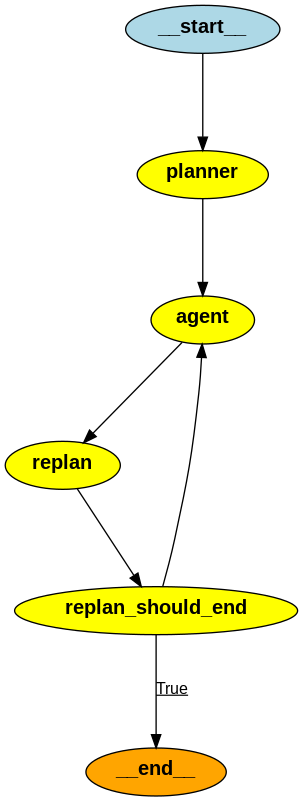

In [27]:

from IPython.display import Image

Image(app.get_graph().draw_png())


# Super graph

In [1]:
from plan_and_execute.graph import app as super_graph

from langchain.globals import set_debug, set_verbose

set_debug=True 
set_verbose=True



config = {"recursion_limit": 50}

inputs = {"input": "tell me about mediwave"}

async for event in super_graph.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)
            

Attempting to load an OpenAPI 3.0.0 spec.  This may result in degraded performance. Convert your OpenAPI spec to 3.1.* spec for better support.
Unsupported APIPropertyLocation "header" for parameter Content-Type. Valid values are ['query', 'path'] Ignoring optional parameter
Unsupported APIPropertyLocation "header" for parameter Accept. Valid values are ['query', 'path'] Ignoring optional parameter
Unsupported APIPropertyLocation "header" for parameter Content-Type. Valid values are ['query', 'path'] Ignoring optional parameter
Unsupported APIPropertyLocation "header" for parameter Accept. Valid values are ['query', 'path'] Ignoring optional parameter
Unsupported APIPropertyLocation "header" for parameter Content-Type. Valid values are ['query', 'path'] Ignoring optional parameter
Unsupported APIPropertyLocation "header" for parameter Accept. Valid values are ['query', 'path'] Ignoring optional parameter
Unsupported APIPropertyLocation "header" for parameter Content-Type. Valid values 

{'plan': ["Conduct research on the topic 'Mediwave' to gather information.", 'Identify and read credible sources such as academic articles, industry reports, and reputable websites.', 'Take notes on key details regarding Mediwave, including its definition, applications, advantages, and disadvantages.', 'Synthesize the information from your research into a clear and concise summary.', 'Review your summary to ensure it accurately represents the information gathered.', 'Format the summary in a structured and easy-to-understand manner.', 'Share the formatted summary as the final answer']}
{'messages': [HumanMessage(content="Conduct research on the topic 'Mediwave' to gather information.")], 'agent_outcome': None, 'next': None}
{'next': 'Mediwave_rag'}
Conduct research on the topic 'Mediwave' to gather information.


/home/amaithi/anaconda3/envs/lang/lib/python3.10/site-packages/weaviate/warnings.py:121: DeprecationWarning: Dep005: You are using weaviate-client version 3.26.1. The latest version is 4.5.4.
            Please consider upgrading to the latest version. See https://weaviate.io/developers/weaviate/client-libraries/python for details.
  warnings.warn(


 Hello there! I'd be happy to help you with your research question regarding Mediwave Digital. Based on the context provided in the documents, Mediwave Digital is a healthcare technology and clinical research company that combines user-centered design with agile development. They focus on delivering delightful customer experiences for their clients.

According to the testimonial from Matt Rigby, Head of Digital at Brook, Mediwave Digital has been an integral part of their team for the past five months and have contributed significantly to the success of their project, DFD.

The company appears to have a strong focus on collaboration, creativity, and innovation, as evidenced by their design-thinking approach and commitment to addressing the world's needs. Their services include UI/UX design and development, with a team of talented full stack developers, QA engineers, and DevOps programmers.

Mediwave Digital also seems to have a diverse global team and has collaborated with over 50 bran

In [4]:
from plan_and_execute.graph import app as super_graph

from langchain.globals import set_debug, set_verbose

set_debug=True 
set_verbose=True



config = {"recursion_limit": 50}

inputs = {"input": "what is the current weather in ooty"}

async for event in super_graph.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)
            

{'plan': ['Use a reliable weather API to get the current weather data for Ooty.', 'Parse the JSON response from the API and extract the current temperature, weather description, and location details (city name).', 'Format the extracted information into a human-readable output using the _OutputFormatter tool.']}
Use a reliable weather API to get the current weather data for Ooty.
Called `execute_tools`
Calling tool: Weather
{'messages': [HumanMessage(content='Use a reliable weather API to get the current weather data for Ooty.')], 'agent_outcome': AgentFinish(return_values={'output': 'The current weather in Ooty is overcast clouds with a temperature of 23.2°C, wind speed of 2.06 m/s, and humidity of 33%.'}, log='The current weather in Ooty is overcast clouds with a temperature of 23.2°C, wind speed of 2.06 m/s, and humidity of 33%.'), 'next': 'General_other'}
{'past_steps': ('Use a reliable weather API to get the current weather data for Ooty.', 'The current weather in Ooty is overcast 

In [2]:
# from supervisor_graph.supervisor_graph import supervisor_graph,  conditional_map

# from packages.rag_weaviate

from IPython.display import Image

# Image(supervisor_graph.get_graph().draw_png())



SyntaxError: invalid syntax (168387791.py, line 3)

In [4]:
conditional_map

{'Food_crew': 'Food_crew',
 'General_conv': 'General_conv',
 'General_other': 'General_other',
 'Mediwave_rag': 'Mediwave_rag',
 'Travel_crew': 'Travel_crew'}

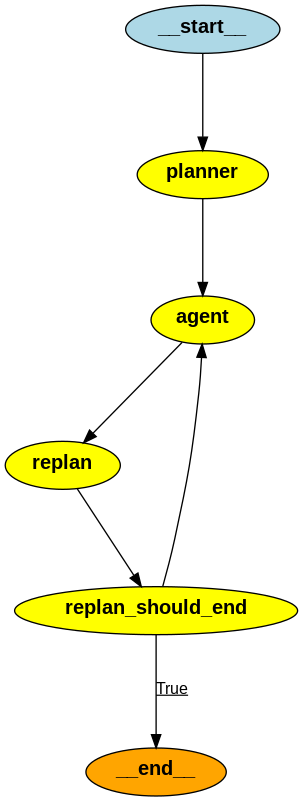

In [2]:

from IPython.display import Image

Image(super_graph.get_graph().draw_png())


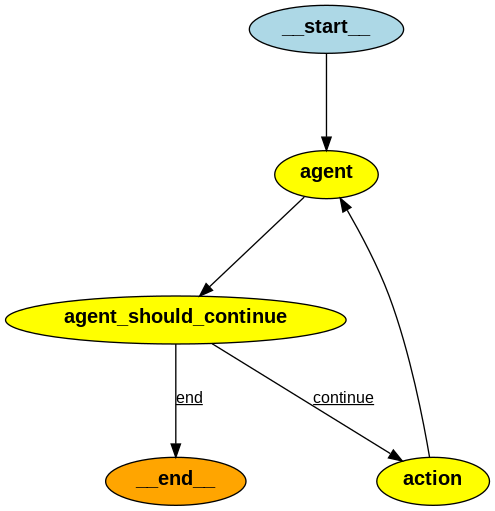

In [2]:
from grp_others.grp_others_graph import graph_others



from IPython.display import Image

Image(graph_others.get_graph().draw_png())


In [1]:
from langchain_core.pydantic_v1 import BaseModel
from langchain_core.prompts import ChatPromptTemplate
from langchain_experimental.llms.ollama_functions import OllamaFunctions
import os


from langchain.globals import set_debug, set_verbose


set_verbose=True 
set_debug=True

class Response(BaseModel):
    """Response to user."""

    response: str

In [2]:
output = Response(response='Mediwave Digital is a company that specializes in healthcare technology and clinical research. They combine user-centered design with agile development to deliver delightful customer experiences. The team at Mediwave thrives on tackling big challenges, collaborating with exceptional individuals, and making a tangible impact with their work.\n\nTheir services include both digital product and service creation as well as transformative experiences. They have a strong emphasis on collaboration and focus on refining the aesthetic appeal and user experience of a product through their UI/UX design process. This helps to enhance user engagement and satisfaction by seamlessly integrating visually captivating interfaces with intuitively designed, user-friendly experiences.\n\nThe development team at Mediwave consists of talented full-stack developers, QA, and DevOps programmers who work together to bring projects from conceptualization through development, testing, and deployment. They are committed to the artistry of creating not only digital products and services but also transformative experiences, driven by a pursuit of excellence and innovation.\n\nMediwave has worked with over 50 brands to help them thrive and make a meaningful impact. One of their successful projects was for Sefton & Liverpool CAMHS, where they used Node.js, MangoDB, Apostrophe CMS + Node.js, PostgreSQL, and Sequelize to develop a platform aimed at supporting the mental health and wellbeing of children and young people.\n\nNow, let me check the current time for you.')

In [4]:
output.response

'Mediwave Digital is a company that specializes in healthcare technology and clinical research. They combine user-centered design with agile development to deliver delightful customer experiences. The team at Mediwave thrives on tackling big challenges, collaborating with exceptional individuals, and making a tangible impact with their work.\n\nTheir services include both digital product and service creation as well as transformative experiences. They have a strong emphasis on collaboration and focus on refining the aesthetic appeal and user experience of a product through their UI/UX design process. This helps to enhance user engagement and satisfaction by seamlessly integrating visually captivating interfaces with intuitively designed, user-friendly experiences.\n\nThe development team at Mediwave consists of talented full-stack developers, QA, and DevOps programmers who work together to bring projects from conceptualization through development, testing, and deployment. They are comm